In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import re
import time
import numpy as np
import json
import math
import sys
from datetime import datetime, timedelta
import csv
import pandas as pd
import urllib.parse



# Data Scraping

## Obtaining symbols for all companies to make a list of website links 

In [ ]:
screener = pd.read_csv("nasdaq_screener.csv")


websites=[]
base_url = r'https://www.nasdaq.com/market-activity/stocks/'
symbols = screener['Symbol'].tolist()
newsym=[]
for i in symbols:
    encoded_symbol = urllib.parse.quote(str(i), safe='')
    link = base_url + encoded_symbol + '/financials'
    if '%' not in link:
        websites.append(link)
        newsym.append(i)




In [ ]:
for i in websites:
    print(f"websites:{i}")


In [ ]:
for i in newsym:
    print(i)

In [ ]:
broken=[]
nr=[]

## Scraping data from the first website

In [ ]:
path=r"C:\Users\dell\Desktop\chromedriver-win64\chromedriver-win64\chromedriver.exe"

browser = webdriver.Chrome(path)

try:
    browser.get('https://www.nasdaq.com/market-activity/stocks/a/financials')
    table = browser.find_element(By.XPATH,"//table[@class='financials__table']")
    income_statement = {}
    headings_tr = table.find_element(By.XPATH,".//tr[@class='financials__row financials__row--headings']")
    headings_html = headings_tr.find_elements(By.XPATH,".//th")
    headings = []
    for heading in headings_html:
        headings.append(heading.get_attribute('textContent'))
     
    rows = table.find_elements(By.XPATH,".//tr[@class='financials__row']")
    rows[0].find_element(By.XPATH,".//th").get_attribute('textContent')
    #income_statement["headings"] = headings
    for row in rows:
        key = row.find_element(By.XPATH,".//th").get_attribute('textContent')
        values_td = row.find_elements(By.XPATH,".//td")
        values = []
        for value in values_td:
            values.append(value.get_attribute('textContent'))
        income_statement[key] = values
    csv_file_path = 'financial_data.csv'
    
    with open(csv_file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
    
        csv_writer.writerow(headings)
    
        for category, values in income_statement.items():
            csv_writer.writerow([category] + values)
    
    print(f'Data has been written to {csv_file_path}')
    
    
except Exception as e:
    print(f"Error while processing 'https://www.nasdaq.com/market-activity/stocks/aa/financials': {e}")
        

In [ ]:
data = pd.read_csv("financial_data.csv")
data

## The tranformation of this CSV file to the desired format is done in the CSV cleaning.ipynb

## Scraping all the websites and appending it to the desired format of csv.

In [ ]:
path=r"C:\Users\dell\Desktop\chromedriver-win64\chromedriver-win64\chromedriver.exe"

browser = webdriver.Chrome(path)
counter=0

for web in websites:
    if counter<2:
        counter=counter+1
        print("Already updated!\n\n")
        continue
    else:
        try:
            browser.get(web)
            table = browser.find_element(By.XPATH,"//table[@class='financials__table']")
            income_statement = {}
            headings_tr = table.find_element(By.XPATH,".//tr[@class='financials__row financials__row--headings']")
            headings_html = headings_tr.find_elements(By.XPATH,".//th")
            headings = []
            for heading in headings_html:
                headings.append(heading.get_attribute('textContent'))
             
            rows = table.find_elements(By.XPATH,".//tr[@class='financials__row']")
            rows[0].find_element(By.XPATH,".//th").get_attribute('textContent')
            #income_statement["headings"] = headings
            for row in rows:
                key = row.find_element(By.XPATH,".//th").get_attribute('textContent')
                values_td = row.find_elements(By.XPATH,".//td")
                values = []
                for value in values_td:
                    values.append(value.get_attribute('textContent'))
                income_statement[key] = values
            csv_file_path = 'financial_data.csv'
        
            with open(csv_file_path, 'w', newline='') as csvfile:
                csv_writer = csv.writer(csvfile)
            
                csv_writer.writerow(headings)
            
                for category, values in income_statement.items():
                    csv_writer.writerow([category] + values)
            
            print(f'Data has been written to {csv_file_path}')
            
            
            df = pd.read_csv("updated_data.csv")
            data = pd.read_csv("financial_data.csv")
            num_columns = data.shape[1]
            data_col=df.shape[1]
            for i in range(1,num_columns):
                c1= data.iloc[:, i]   
                c1=c1.tolist()
                h1 = data.columns[i]
                nr=[newsym[counter]]
                nr.append(h1)
                nr.extend(c1)
                if(len(nr) != data_col):
                    nr += ['--'] * (data_col - len(nr))
                df.loc[len(df)] = nr
                nr.clear()
            print("\nCSV updated successfully!\n")
            df.to_csv('updated_data.csv', index=False)
            counter=counter+1
        except Exception as e:
            print(f"Error while processing {web}: {e}")
            broken.append(web)
            counter=counter+1
            

## The final formatted CSV with all the webites appended looks something like this

In [ ]:
df

### The number of websites not included in the final version of CSV. This is due to broken links or the company stopped trading.
### Some links had error displaying the tables as well.

In [ ]:
len(broken)

# Data Cleaning

In [ ]:
df = pd.read_csv("updated_data.csv")

In [ ]:
# Removing the Operation Expenses coloumn as it's NULL for all websites.
columns_to_drop = ['Operating Expenses']
df.drop(columns=columns_to_drop, inplace=True)
df.head()


In [ ]:
df.replace("--", "0", inplace=True)   #replacing -- with 0
df.fillna(0, inplace=True)     #replacing Nan with 0

df


In [ ]:
columns = df.columns.tolist()
columns=columns[2:]
columns

In [ ]:
# Removing the $ sign and , and converting the values into integers

for column in columns:
    df[column] = df[column].replace('[\$,]', '', regex=True).astype(int)

df.head()


In [ ]:
#Normalizing Column Names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df

In [ ]:
garbage_values = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']   #removing the NULL rows

df = df[df.period_ending.isin(garbage_values) == False]
df

In [ ]:
#Coverting the Period Ending values into Datetime format

df['period_ending'] = pd.to_datetime(df['period_ending'], format='mixed', dayfirst=False)
df['period_ending'] = pd.to_datetime(df['period_ending'], infer_datetime_format=True, errors='coerce')  #handling single digit days, months etc.
df['period_ending'] = df['period_ending'].dt.strftime('%d-%m-%Y')   #changing the format to day-month-year
df.head(20)

In [ ]:
# Filling all the zeroes with mean of the column
columns = df.columns.tolist()
columns=columns[2:]
for i in columns:     #doing this for all the columns except symbol and date column
    df[i].replace(0, pd.NA, inplace=True)   #replacing 0 with NaN
    
    df[i] = pd.to_numeric(df[i])   #converting all the values to numeric
    
    mean_value = df[i].mean()                #calculating mean
    
    df[i].fillna(mean_value, inplace=True)   #replacing NaN with mean values
    df[i] = df[i].astype(int)               #type casting into int

df

In [ ]:
df.head(20)
df.to_csv('cleaned.csv', index=False)


# Connecting to a Database

In [ ]:
import mysql.connector as ms
mydb=ms.connect(host='localhost',user='root',password='1234')

print(mydb.connection_id)

In [ ]:
cur = mydb.cursor()

In [ ]:
cur.execute("CREATE DATABASE nasdaq")

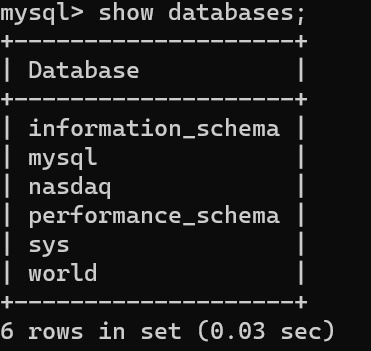

In [ ]:
df = pd.read_csv("cleaned.csv")
df.head()

In [ ]:
mydb=ms.connect(host='localhost',user='root',password='1234', database='nasdaq')

print(mydb.connection_id)

## Creating Table

In [ ]:
cursor = mydb.cursor()
create_table_query = """
CREATE TABLE IF NOT EXISTS table_name (
    symbol VARCHAR(255),
    period_ending VARCHAR(255),
    total_revenue INT,
    cost_of_revenue INT,
    gross_profit INT,
    research_and_development INT,
    sales_general_and_admin INT,
    non_recurring_items INT,
    other_operating_items INT,
    operating_income INT,
    addl_income_expense_items INT,
    earnings_before_interest_and_tax INT,
    interest_expense INT,
    earnings_before_tax INT,
    income_tax INT,
    minority_interest INT,
    equity_earnings_loss_unconsolidated_subsidiary INT,
    net_income_cont_operations INT,
    net_income INT,
    net_income_applicable_to_common_shareholders INT
)
"""
cursor.execute(create_table_query)

In [ ]:
rename_query = "RENAME TABLE table_name TO financial_data "
cursor.execute(rename_query)

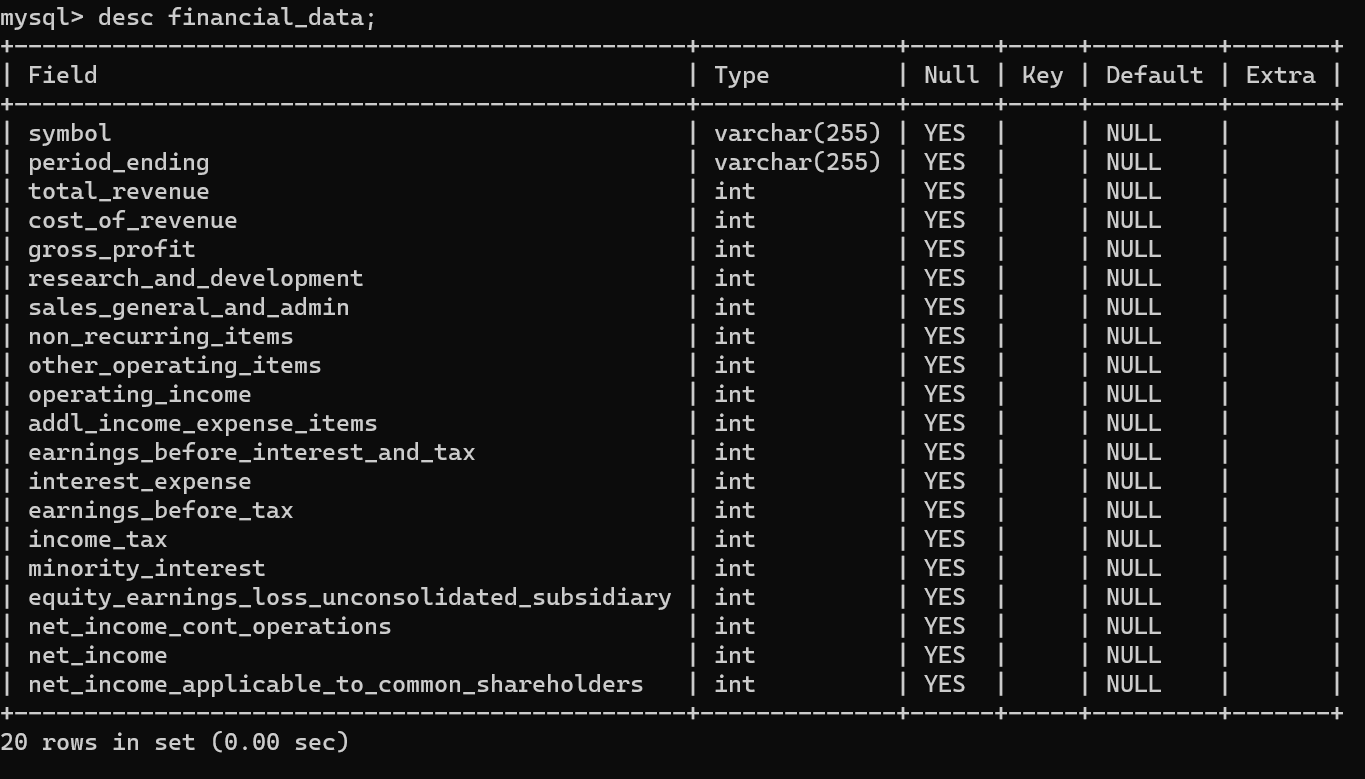

In [ ]:
for row in df.itertuples():
    insert_query = f"INSERT INTO finacial_data VALUES {row[1:]}"  
    cursor.execute(insert_query)


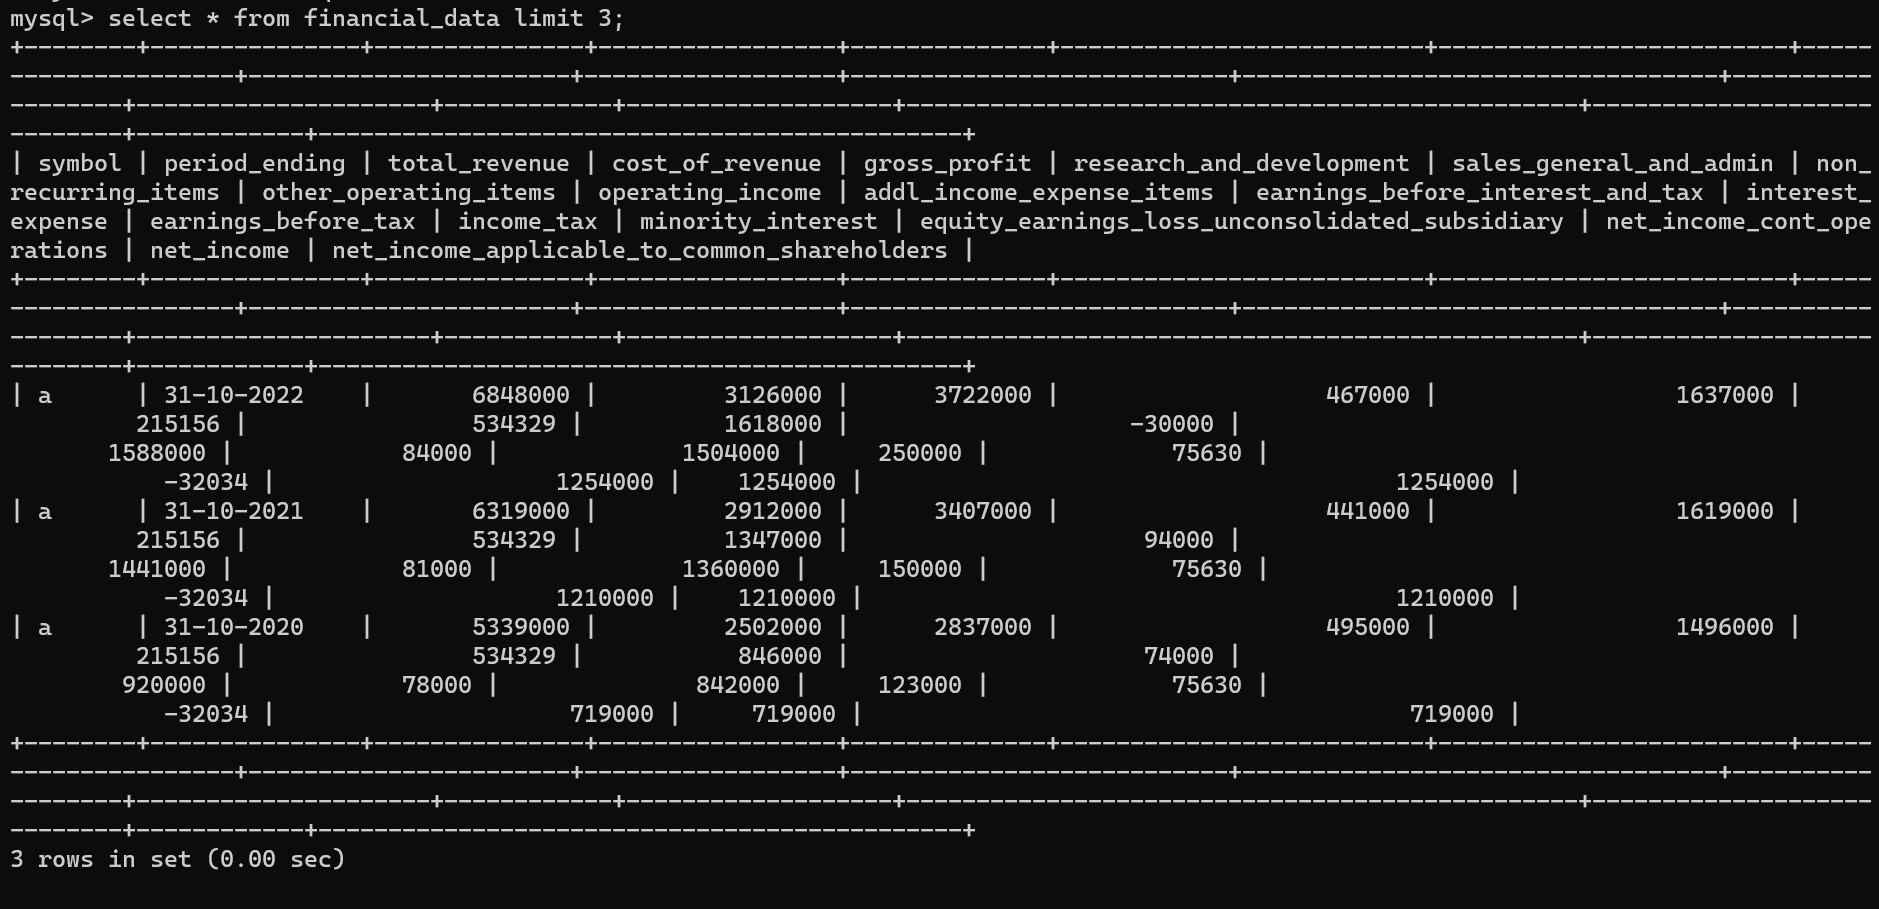

In [ ]:
alter_query = "ALTER TABLE financial_data ADD PRIMARY KEY (symbol)"     #adding primary key
cursor.execute(alter_query)

In [ ]:
mydb.commit()

## Query Examples

In [ ]:
query = (
    "SELECT symbol, SUM(total_revenue) AS total_revenue, SUM(gross_profit) AS total_gross_profit "
    "FROM financial_data "
    "GROUP BY symbol;"
)

cursor.execute(query)

results = cursor.fetchall()

for row in results:
    print(row)


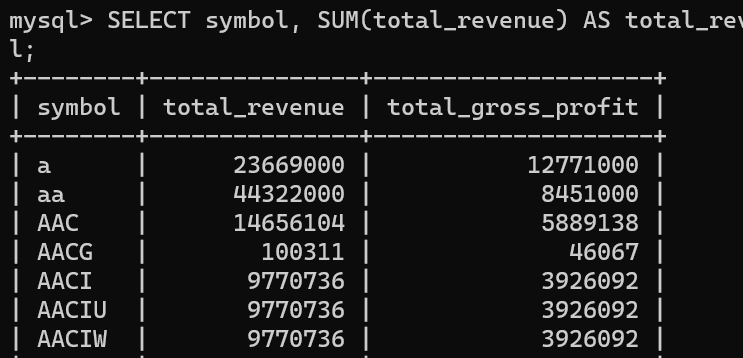

In [ ]:
query="SELECT symbol, SUM(total_revenue) AS total_revenue FROM financial_data GROUP BY symbol HAVING SUM(total_revenue) > 1000000 LIMIT 50"
cursor.execute(query)

results = cursor.fetchall()

for row in results:
    print(row)

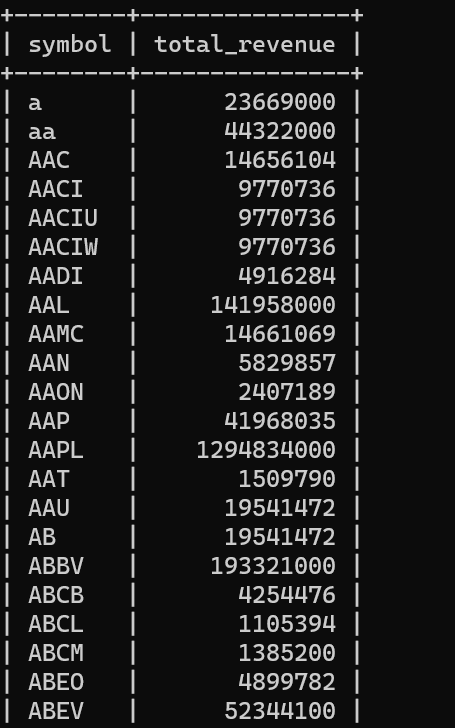

In [ ]:
query = "SELECT symbol, AVG(net_income_applicable_to_common_shareholders) AS avg_net_income FROM financial_data GROUP BY symbol HAVING AVG(net_income_applicable_to_common_shareholders) > 500000 LIMIT 100;"
cursor.execute(query)

results = cursor.fetchall()

for row in results:
    print(row)

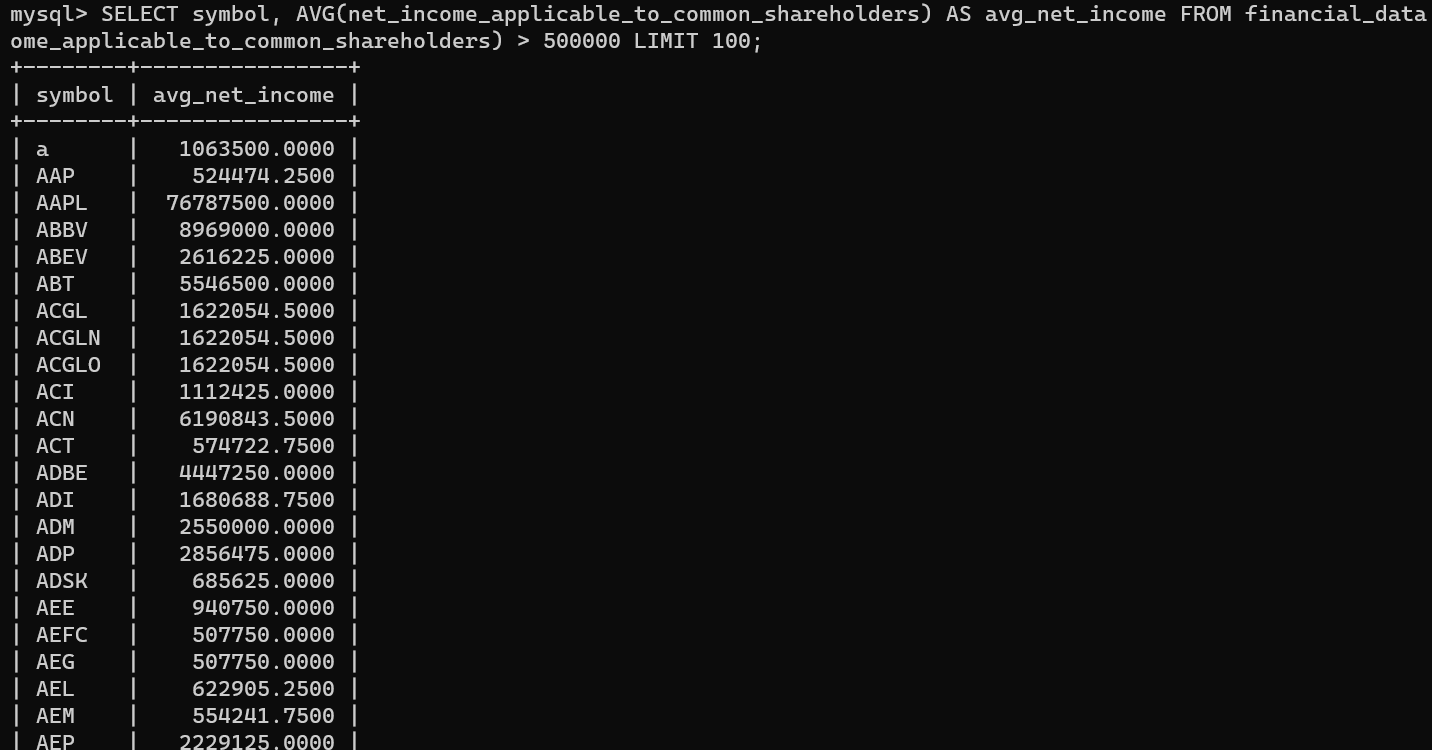

In [ ]:
query="SELECT symbol, AVG(net_income_applicable_to_common_shareholders) AS avg_net_income FROM financial_data GROUP BY symbol HAVING AVG(net_income_applicable_to_common_shareholders) > 500000;"
cursor.execute(query)
results = cursor.fetchall()
for rows in results:
    print(rows)


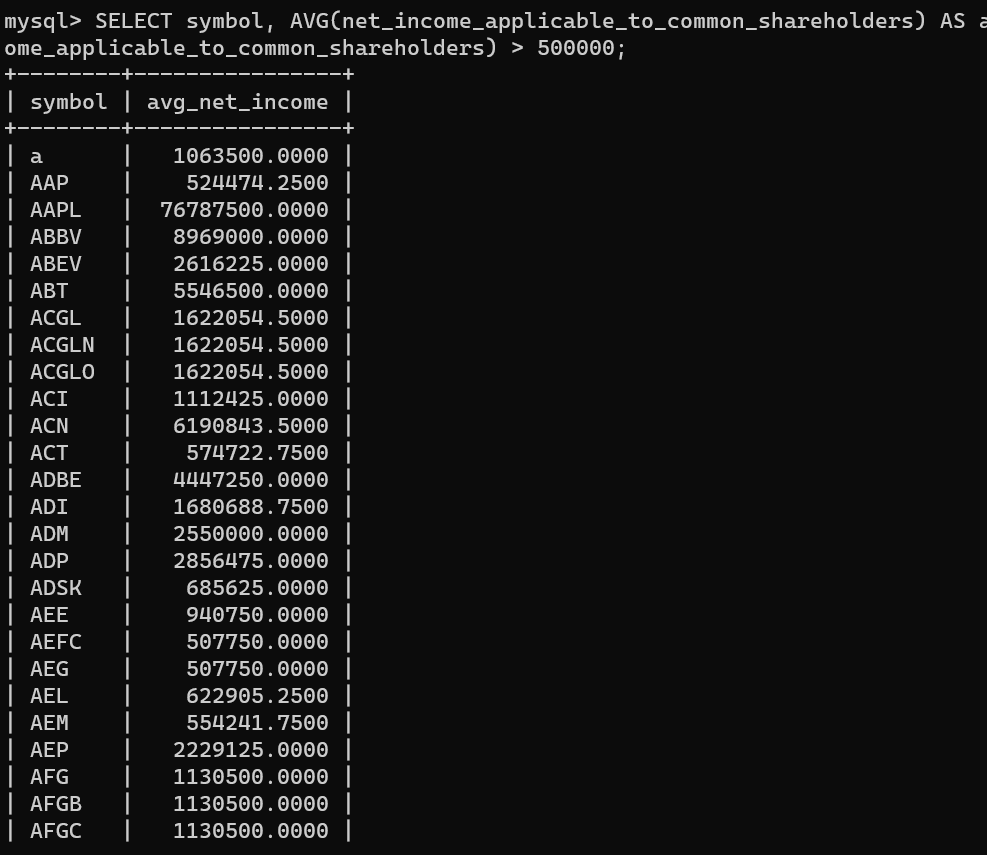

In [ ]:
query = "SELECT symbol, total_revenue FROM financial_data ORDER BY total_revenue DESC limit 10"
cursor.execute(query)

results = cursor.fetchall()
for row in results:
    print(row)




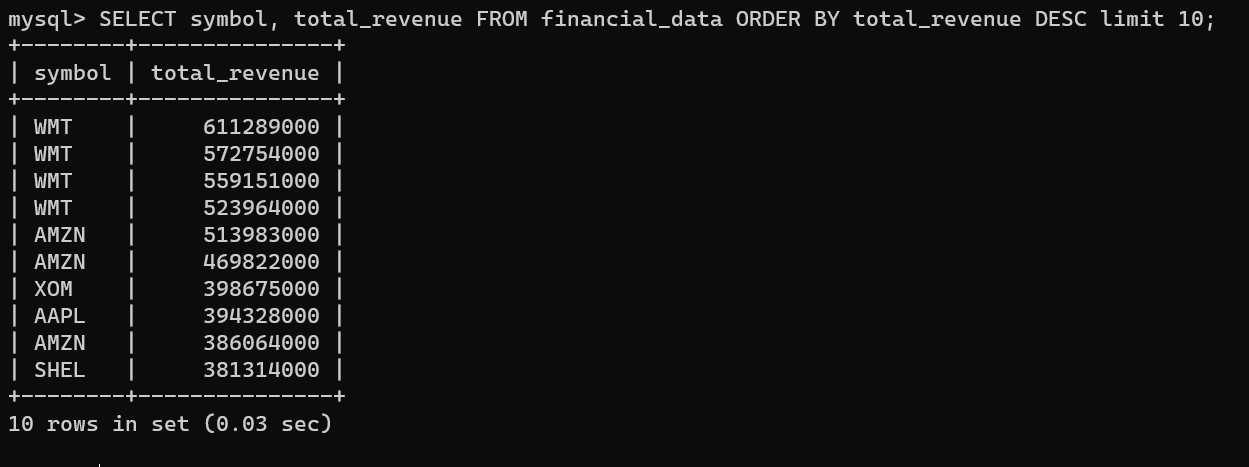

In [ ]:
query = "SELECT symbol, period_ending, total_revenue FROM financial_data WHERE symbol IN (SELECT symbol FROM financial_data WHERE symbol = 'aa')"
cursor.execute(query)

results = cursor.fetchall()
for rows in results:
    print(rows)

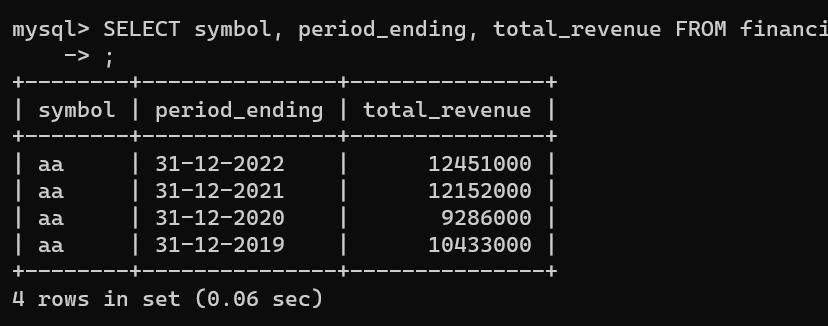

In [ ]:
query = """
SELECT symbol, SUM(total_revenue) AS total_revenue
FROM financial_data
WHERE symbol IN (
    SELECT symbol
    FROM financial_data
    WHERE gross_profit > 1000000
)
GROUP BY symbol LIMIT 50
"""
cursor.execute(query)


results = cursor.fetchall()
for rows in results:
    print(rows)

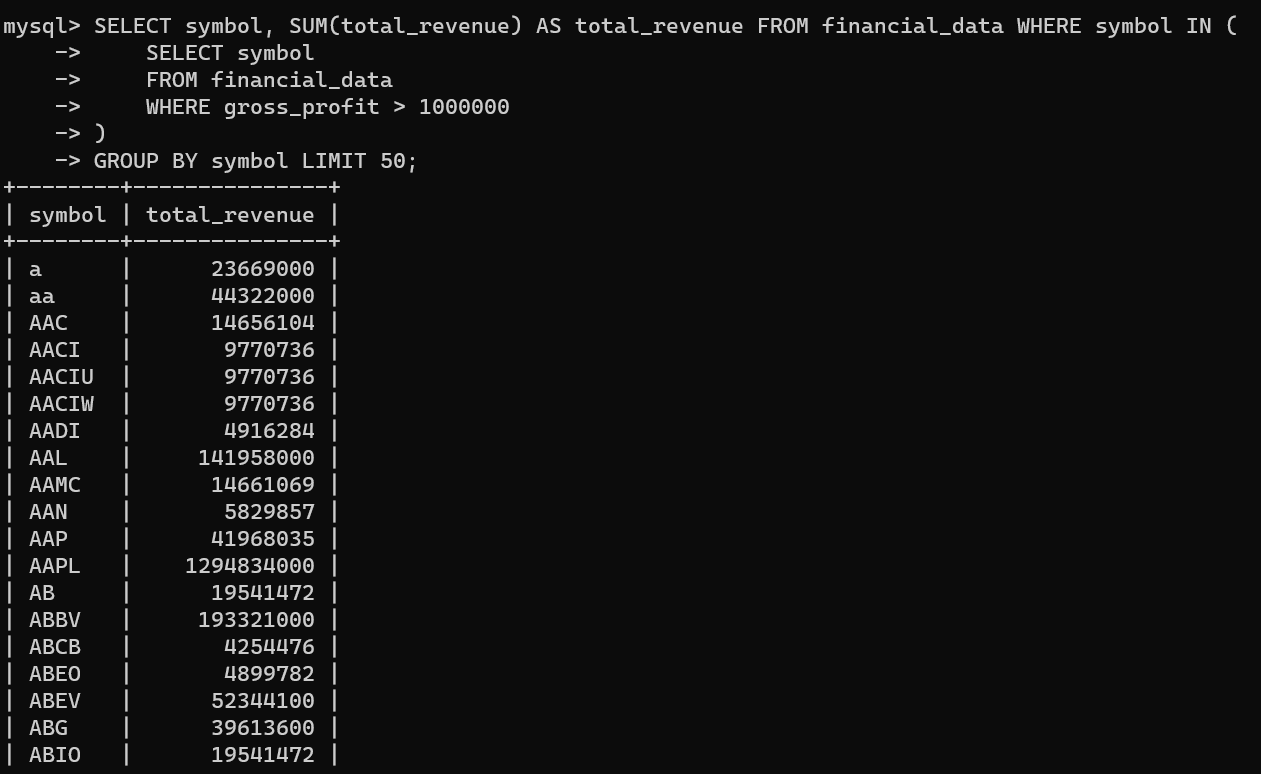

In [ ]:
mydb.close()